In [1]:
# This model aims to predict the Dutch electricity price by using a univariate Long-Short Term Memory (LSTM) model 
# The input data is from 2015 to 2021
# In research, the LSTM models proved useful to predict sequential data because it remembers past patterns

In [2]:
#Import libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf  
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Read excel file in variable
df = pd.read_excel(r'C:\Users\tom.rigter\PPAnalytics\EPEXSPOT.xlsx')
df = df.dropna()
df.head()

,Date,Time,EPEX_SPOT_NL
0,2015-01-01,00:00:00,38.50
1,2015-01-01,01:00:00,38.22
2,2015-01-01,02:00:00,35.60
3,2015-01-01,03:00:00,33.00
4,2015-01-01,04:00:00,27.41


In [4]:
# Convert columns so they can be merged and indexed
df['Date'] = df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['Time'] = df['Time'].apply(lambda x: x.strftime('%H:%M:%S'))
df.index = pd.to_datetime(df['Date'] + " " + df['Time'], format='%Y-%m-%d %H:%M:%S')

,EPEX_SPOT_NL
count,63043.000000
mean,52.738938
std,47.526811
min,-79.190000
25%,31.520000
50%,40.370000
75%,53.520000
max,700.000000


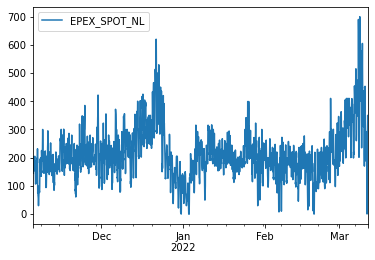

In [5]:
# Plot and properties of dataframe
df[60000:].plot(y='EPEX_SPOT_NL', use_index=True)
df.describe()

In [6]:
# Define seasonality columns
df['Hour'] = df.index.hour
df['Weekday'] = df.index.dayofweek
df['Month'] = df.index.month

In [7]:
df.head()

,Date,Time,EPEX_SPOT_NL,Hour,Weekday,Month
2015-01-01 00:00:00,2015-01-01,00:00:00,38.50,0,3,1
2015-01-01 01:00:00,2015-01-01,01:00:00,38.22,1,3,1
2015-01-01 02:00:00,2015-01-01,02:00:00,35.60,2,3,1
2015-01-01 03:00:00,2015-01-01,03:00:00,33.00,3,3,1
2015-01-01 04:00:00,2015-01-01,04:00:00,27.41,4,3,1


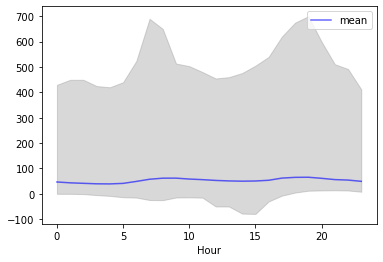

In [8]:
# Plot hourly data
hourly_data = df.groupby('Hour')['EPEX_SPOT_NL'].agg(['min','max','mean'])
hourly_data.reset_index(inplace=True)

ax  = hourly_data.plot(x='Hour', y='mean', c='blue', alpha=0.6)
plt.fill_between(x='Hour',y1='min',y2='max', data=hourly_data, color='grey', alpha=0.3)

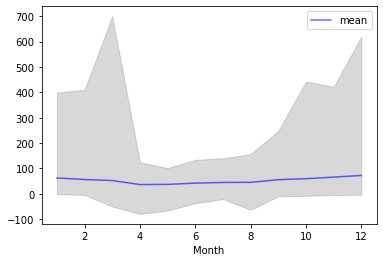

In [9]:
# Plot monthly data
monthly_data = df.groupby('Month')['EPEX_SPOT_NL'].agg(['min','max','mean'])
monthly_data.reset_index(inplace=True)

ax  = monthly_data.plot(x='Month', y='mean', c='blue', alpha=0.6)
plt.fill_between(x='Month',y1='min',y2='max', data=monthly_data, color='grey', alpha=0.3)

<AxesSubplot:ylabel='EPEX_SPOT_NL'>

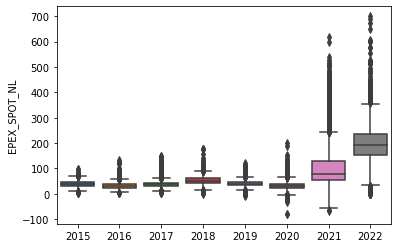

In [10]:
# Plot yearly data
sns.boxplot(x=df.index.year, y='EPEX_SPOT_NL', data=df)

In [11]:
# normalization of data
values = df['EPEX_SPOT_NL'].values
values = values.reshape((-1, 1))

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f,Max: %f' % (scaler.data_min_, scaler.data_max_))

normalized = scaler.transform(values)
df['Normalized EPEX'] = normalized

Min: -79.190000,Max: 700.000000


In [12]:
# Function for processing DataFrame to array for LSTM model
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_xy(df, window_size=5):
    df_as_np = df.to_numpy()
    x = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        x.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(x), np.array(y) 

In [13]:
# Pre-process data for LSTM
WINDOWSIZE = 5
temp = df['Normalized EPEX']
x, y = df_to_xy(temp, WINDOWSIZE)
x.shape, y.shape

((63038, 5, 1), (63038,))

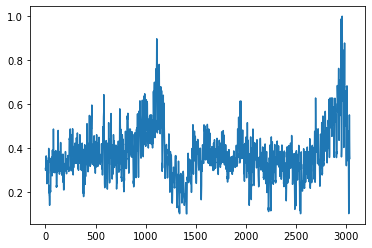

In [14]:
# Split data in train- and testset
x_train, y_train = x[:55000],y[:55000]
x_val, y_val = x[55000:60000],y[55000:60000]
x_test, y_test = x[60000:],y[60000:]

plt.plot(y_test)

In [15]:
# LSTM model with 3 layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model_1 = Sequential()
model_1.add(InputLayer((5, 1)))
model_1.add(LSTM(64))
model_1.add(Dense(8))
model_1.add(Dense(1))
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Add model specifications
cp = ModelCheckpoint('model_1/', save_best_only=True)
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [17]:
# Fit the model to training data
model_1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
1719/1719 [==============================] - ETA: 0s - loss: 5.7824e-04 - root_mean_squared_error: 0.0240

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 22s 11ms/step - loss: 5.7824e-04 - root_mean_squared_error: 0.0240 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0512
Epoch 2/10
1714/1719 [============================>.] - ETA: 0s - loss: 1.5766e-04 - root_mean_squared_error: 0.0126

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 20s 12ms/step - loss: 1.5752e-04 - root_mean_squared_error: 0.0126 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 3/10
1714/1719 [============================>.] - ETA: 0s - loss: 1.3566e-04 - root_mean_squared_error: 0.0116

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 19s 11ms/step - loss: 1.3558e-04 - root_mean_squared_error: 0.0116 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 4/10
1708/1719 [============================>.] - ETA: 0s - loss: 1.1328e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 18s 11ms/step - loss: 1.1308e-04 - root_mean_squared_error: 0.0106 - val_loss: 9.8134e-04 - val_root_mean_squared_error: 0.0313
Epoch 5/10
1715/1719 [============================>.] - ETA: 0s - loss: 9.0261e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 22s 13ms/step - loss: 9.0226e-05 - root_mean_squared_error: 0.0095 - val_loss: 7.5336e-04 - val_root_mean_squared_error: 0.0274
Epoch 6/10
1711/1719 [============================>.] - ETA: 0s - loss: 7.6418e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 19s 11ms/step - loss: 7.6488e-05 - root_mean_squared_error: 0.0087 - val_loss: 6.3778e-04 - val_root_mean_squared_error: 0.0253
Epoch 7/10
1715/1719 [============================>.] - ETA: 0s - loss: 7.0205e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 18s 10ms/step - loss: 7.0170e-05 - root_mean_squared_error: 0.0084 - val_loss: 6.0138e-04 - val_root_mean_squared_error: 0.0245
Epoch 8/10
1714/1719 [============================>.] - ETA: 0s - loss: 6.5346e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 18s 10ms/step - loss: 6.5337e-05 - root_mean_squared_error: 0.0081 - val_loss: 5.4706e-04 - val_root_mean_squared_error: 0.0234
Epoch 9/10
1718/1719 [============================>.] - ETA: 0s - loss: 6.1606e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 18s 10ms/step - loss: 6.1604e-05 - root_mean_squared_error: 0.0078 - val_loss: 5.3493e-04 - val_root_mean_squared_error: 0.0231
Epoch 10/10
1707/1719 [============================>.] - ETA: 0s - loss: 5.9262e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 18s 10ms/step - loss: 5.9257e-05 - root_mean_squared_error: 0.0077 - val_loss: 4.5111e-04 - val_root_mean_squared_error: 0.0212


In [18]:
# Import the best performing model 

from tensorflow.keras.models import load_model

model_1 = load_model('model_1/')

1719/1719 [==============================] - 3s 2ms/step


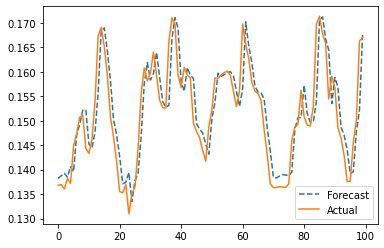

In [33]:
# Plot trained data & actuals
train_predictions = model_1.predict(x_train).flatten()
train_results = pd.DataFrame(data={'train predictions':train_predictions, 'actuals':y_train})
plt.plot(train_results['train predictions'][:100], label="Forecast",linestyle='dashed')
plt.plot(train_results['actuals'][:100], label="Actual")
plt.legend()
plt.show()

95/95 [==============================] - 0s 3ms/step


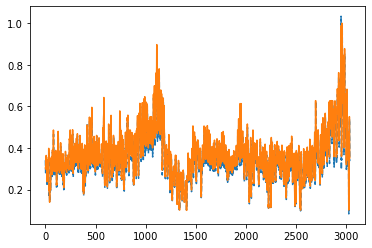

In [32]:
# Plot trained data & actuals
test_predictions = model_1.predict(x_test).flatten()
test_results = pd.DataFrame(data={'test predictions':test_predictions, 'actuals':y_test})
plt.plot(test_results['test predictions'],linestyle='dashed')
plt.plot(test_results['actuals'])
plt.show()

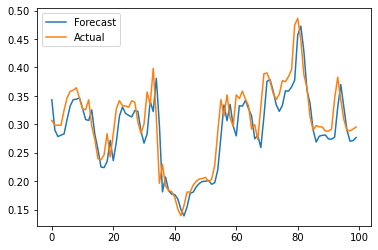

In [31]:
# Plot trained data & actuals (first 100)
plt.plot(test_results['test predictions'][:100], label="Forecast",linestyle='dashed')
plt.plot(test_results['actuals'][:100], label="Actual")
plt.legend()
plt.show()

In [22]:
# Predict the first 5 hours in the future 
future_data = df['Normalized EPEX'].values.reshape((-1))

def predict(num_prediction, model):
    prediction_list = future_data[-WINDOWSIZE:]
    
    for _ in range(num_prediction):
        x = prediction_list[-WINDOWSIZE:]
        x = x.reshape((1, WINDOWSIZE, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[WINDOWSIZE-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1, freq='H').tolist()
    return prediction_dates

num_prediction = 5
forecast = predict(num_prediction, model_1)
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 23ms/step


In [23]:
# Denormalize the forecast data
denormalized_forecast = forecast.reshape((-1,1))
denormalized_forecast = scaler.inverse_transform(denormalized_forecast)
denormalized_forecast


array([[195.53      ],
       [179.64351189],
       [164.79269559],
       [150.64185014],
       [137.67851453],
       [126.09438366]])

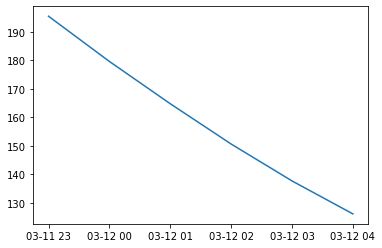

In [24]:
# Plot the first five forecast values
denormalized_forecast = denormalized_forecast.reshape(-1)
forecast_result = pd.DataFrame(data={'predictions':denormalized_forecast, 'date-time':forecast_dates})
forecast_result.index = forecast_result['date-time']
forecast_result.index = pd.to_datetime(forecast_result['date-time'], format='%Y-%m-%d %H:%M:%S')

plt.plot(forecast_result['date-time'],denormalized_forecast)

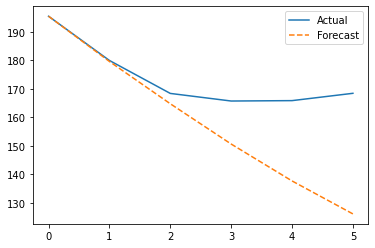

In [34]:
# Did it work???
test_data = pd.read_excel(r'C:\Users\tom.rigter\PPAnalytics\Test.xlsx')

plt.plot(test_data['EPEX_SPOT_NL'],label='Actual')
plt.plot(denormalized_forecast,label='Forecast',linestyle='dashed')
plt.legend()
plt.show()